In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [40]:
import root_numpy
import pandas
from rep.data import LabeledDataStorage
from hep_ml.decisiontrain import DecisionTrainClassifier
from hep_ml.losses import LogLossFunction
from rep.metaml import FoldingClassifier
from rep.report import ClassificationReport
from rep.report.metrics import RocAuc
from sklearn.metrics import roc_auc_score

In [3]:
treename = 'tag'

data_b = pandas.DataFrame(root_numpy.root2array('datasets/type=5.root', treename=treename)).dropna()
data_c = pandas.DataFrame(root_numpy.root2array('datasets/type=4.root', treename=treename)).dropna()
data_light = pandas.DataFrame(root_numpy.root2array('datasets/type=0.root', treename=treename)).dropna()

In [4]:
data = {'b': data_b, 'c': data_c, 'light': data_light}

In [5]:
for d in data.values():
    d['log_SVFDChi2'] = numpy.log(d['SVFDChi2'].values)
    d['log_SVSumIPChi2'] = numpy.log(d['SVSumIPChi2'].values)

In [6]:
len(data_b), len(data_c), len(data_light)

(1843595, 19941, 42423)

In [7]:
jet_features = [column for column in data_b.columns if "Jet" in column]
sv_features = [column for column in data_b.columns if "SV" in column]

In [8]:
print "Jet features", ", ".join(jet_features)
print "SV features", ", ".join(sv_features)

Jet features JetParton, JetFlavor, JetPx, JetPy, JetPz, JetE, JetQ, JetSigma1, JetSigma2, JetMult, JetPTHard, JetPTD, JetNDis
SV features SVM, SVMC, SVR, SVPT, SVDR, SVN, SVQ, SVFDChi2, SVSumIPChi2, log_SVFDChi2, log_SVSumIPChi2


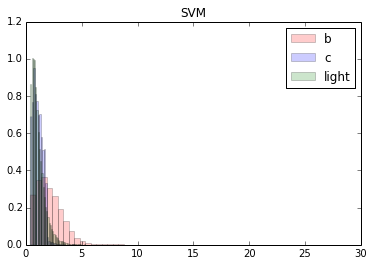

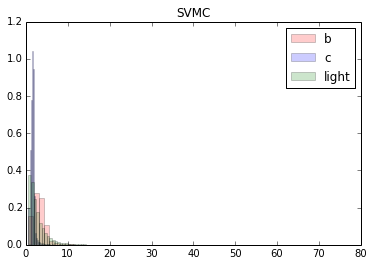

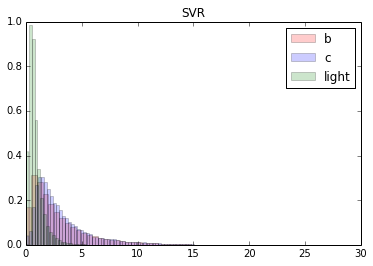

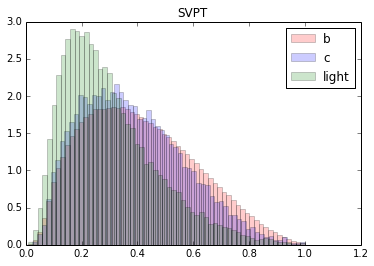

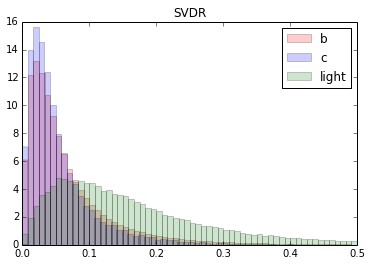

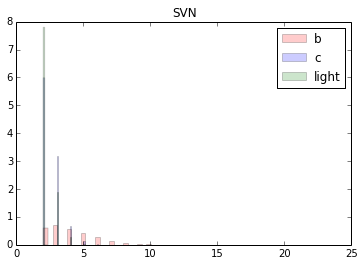

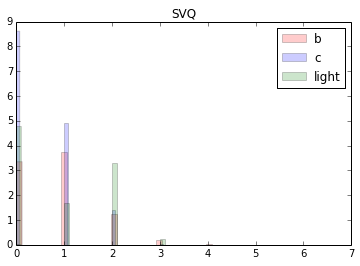

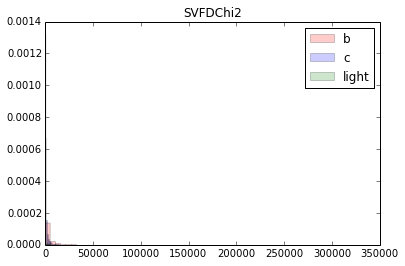

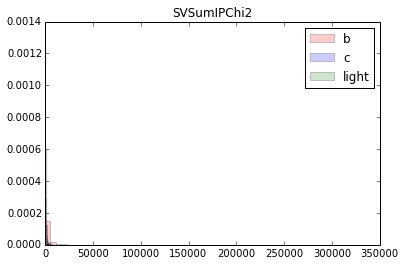

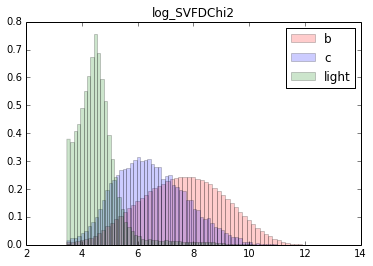

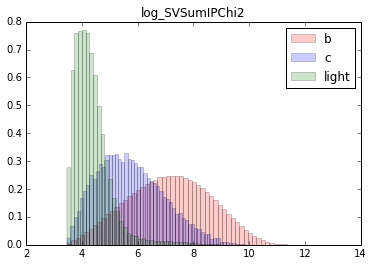

In [9]:
for feature in sv_features:
    hist(data_b[feature].values, label='b', alpha=0.2, bins=60, normed=True)
    hist(data_c[feature].values, label='c', alpha=0.2, bins=60, normed=True)
    hist(data_light[feature].values, label='light', alpha=0.2, bins=60, normed=True)
    title(feature); legend(loc='best'); show()

# Old scheme

## Prepare datasets:
* b vs c
* b, c vs light

In [10]:
data_b_c_lds = LabeledDataStorage(pandas.concat([data_b, data_c]), [1] * len(data_b) + [0] * len(data_c))
data_bc_light_lds = LabeledDataStorage(pandas.concat([data_b, data_c, data_light]), 
                                       [1] * len(data_b) + [1] * len(data_c) + [0] * len(data_light))

### b vs c jets

In [11]:
tt_base = DecisionTrainClassifier(learning_rate=0.02, n_estimators=5000, depth=6, pretransform_needed=True, 
                                  max_features=6, loss=LogLossFunction(regularization=100))
tt_folding_b_c = FoldingClassifier(tt_base, n_folds=2, random_state=11, ipc_profile='ssh-ipy', features=sv_features)
%time tt_folding_b_c.fit_lds(data_b_c_lds)
pass

CPU times: user 3min 8s, sys: 18.8 s, total: 3min 27s
Wall time: 29min 31s


In [23]:
report = ClassificationReport({'tt b vs c': tt_folding_b_c}, data_b_c_lds)

KFold prediction using folds column


Default prediction


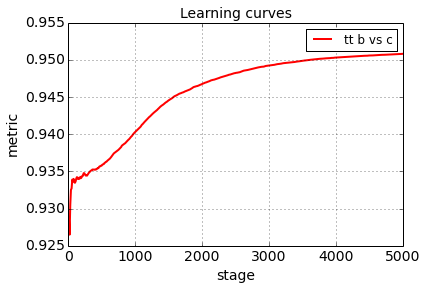

In [24]:
report.learning_curve(RocAuc())

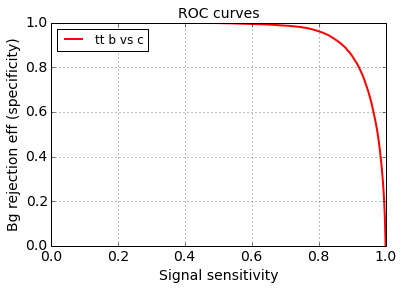

In [25]:
report.roc()

In [26]:
report.compute_metric(RocAuc())

OrderedDict([('tt b vs c', 0.95080936901873503)])

### b, c vs light jets

In [ ]:
tt_base = DecisionTrainClassifier(learning_rate=0.02, n_estimators=5000, depth=6, pretransform_needed=True, 
                                  max_features=6, loss=LogLossFunction(regularization=100))
tt_folding_bc_light = FoldingClassifier(tt_base, n_folds=2, random_state=11,
                                        ipc_profile='ssh-ipy', features=sv_features)
%time tt_folding_bc_light.fit_lds(data_bc_light_lds)
pass

CPU times: user 2min 39s, sys: 14 s, total: 2min 53s
Wall time: 24min 41s


In [27]:
report = ClassificationReport({'tt b, c vs light': tt_folding_bc_light}, data_bc_light_lds)

KFold prediction using folds column


Default prediction


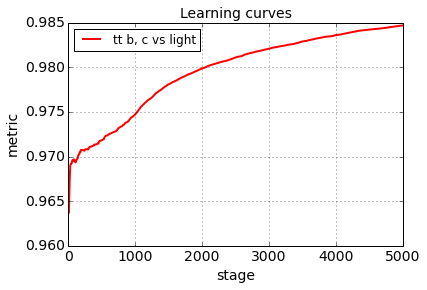

In [28]:
report.learning_curve(RocAuc())

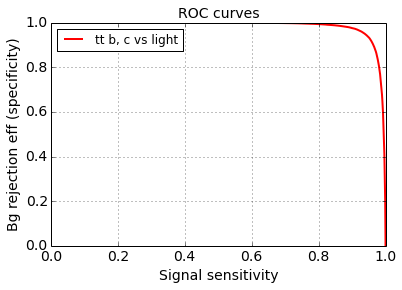

In [29]:
report.roc()

In [30]:
report.compute_metric(RocAuc())

OrderedDict([('tt b, c vs light', 0.98468153254383894)])

In [ ]:
p_b_c = tt_folding_b_c.predict_proba(pandas.concat([data_b, data_c]))[:, 1]
p_b_c_light = tt_folding_b_c.predict_proba(data_light)[:, 1]
p_bc_light = tt_folding_bc_light.predict_proba(pandas.concat([data_b, data_c, data_light]))[:, 1]

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column


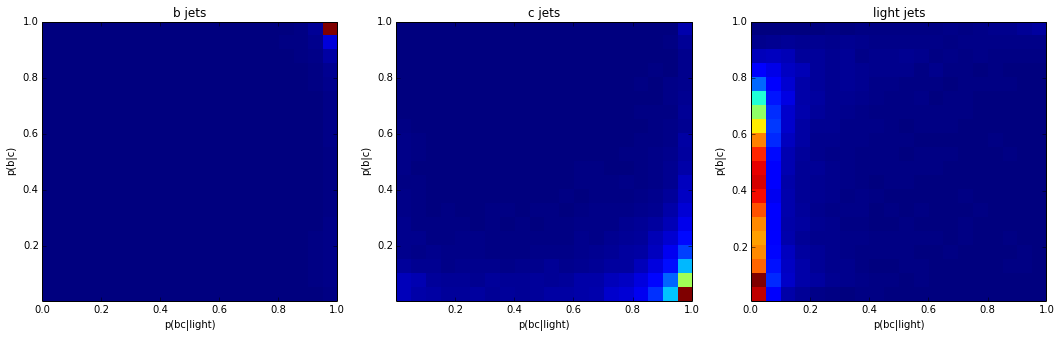

In [117]:
plt.figure(figsize=[18, 5])

plt.subplot(1,3,1)
hist2d(p_bc_light[:len(data_b)], p_b_c[:len(data_b)], normed=True, bins=20), xlabel('p(bc|light)'), 
ylabel('p(b|c)'), title('b jets')

plt.subplot(1,3,2)
hist2d(p_bc_light[len(data_b):len(data_b) + len(data_c)],
        p_b_c[len(data_b):len(data_b) + len(data_c)], bins=20, normed=True), 
xlabel('p(bc|light)'), ylabel('p(b|c)'), title('c jets')

plt.subplot(1,3,3)
hist2d(p_bc_light[len(data_b) + len(data_c):], p_b_c_light, bins=20, normed=True), xlabel('p(bc|light)'), 
ylabel('p(b|c)'), title('light jets')
pass

# Multiclassification

In [32]:
data_multi_lds = LabeledDataStorage(pandas.concat([data_b, data_c, data_light]), 
                                    [0] * len(data_b) + [1] * len(data_c) + [2] * len(data_light))

In [33]:
from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=300, colsample=0.7, eta=0.01, nthreads=4, 
                             subsample=0.5, max_depth=8)
multi_folding = FoldingClassifier(xgb_base, n_folds=2, random_state=11, features=sv_features)
multi_folding.fit_lds(data_multi_lds)

FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.01, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=300, nthreads=4, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.5, verbose=0),
         features=['SVM', 'SVMC', 'SVR', 'SVPT', 'SVDR', 'SVN', 'SVQ', 'SVFDChi2', 'SVSumIPChi2', 'log_SVFDChi2', 'log_SVSumIPChi2'],
         ipc_profile=None, n_folds=2, random_state=11)

In [34]:
multi_probs = multi_folding.predict_proba(pandas.concat([data_b, data_c, data_light]))

KFold prediction using folds column


In [35]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    names = ['b', 'c', 'light']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [36]:
cm = confusion_matrix([0] * len(data_b) + [1] * len(data_c) + [2] * len(data_light), numpy.argmax(multi_probs, axis=1))

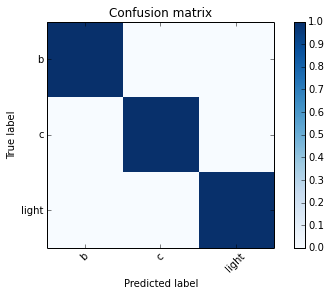

In [86]:
plot_confusion_matrix(cm / numpy.max(cm, axis=0))

In [93]:
labels = numpy.array([0] * len(data_b) + [1] * len(data_c) + [2] * len(data_light))


In [119]:
'log loss', -numpy.log(multi_probs[numpy.arange(len(multi_probs)), labels]).sum() / len(labels)

('log loss', 0.11695901759180406)

In [42]:
roc_auc_score([0] * len(data_b) + [0] * len(data_c) + [1] * len(data_light), multi_probs[:, 2])

0.97964970556942843

In [43]:
multi_probs_b = multi_probs[:len(data_b), :]  
multi_probs_c = multi_probs[len(data_b) : len(data_b) + len(data_c), :]
multi_probs_light = multi_probs[len(data_b) + len(data_c):, :]

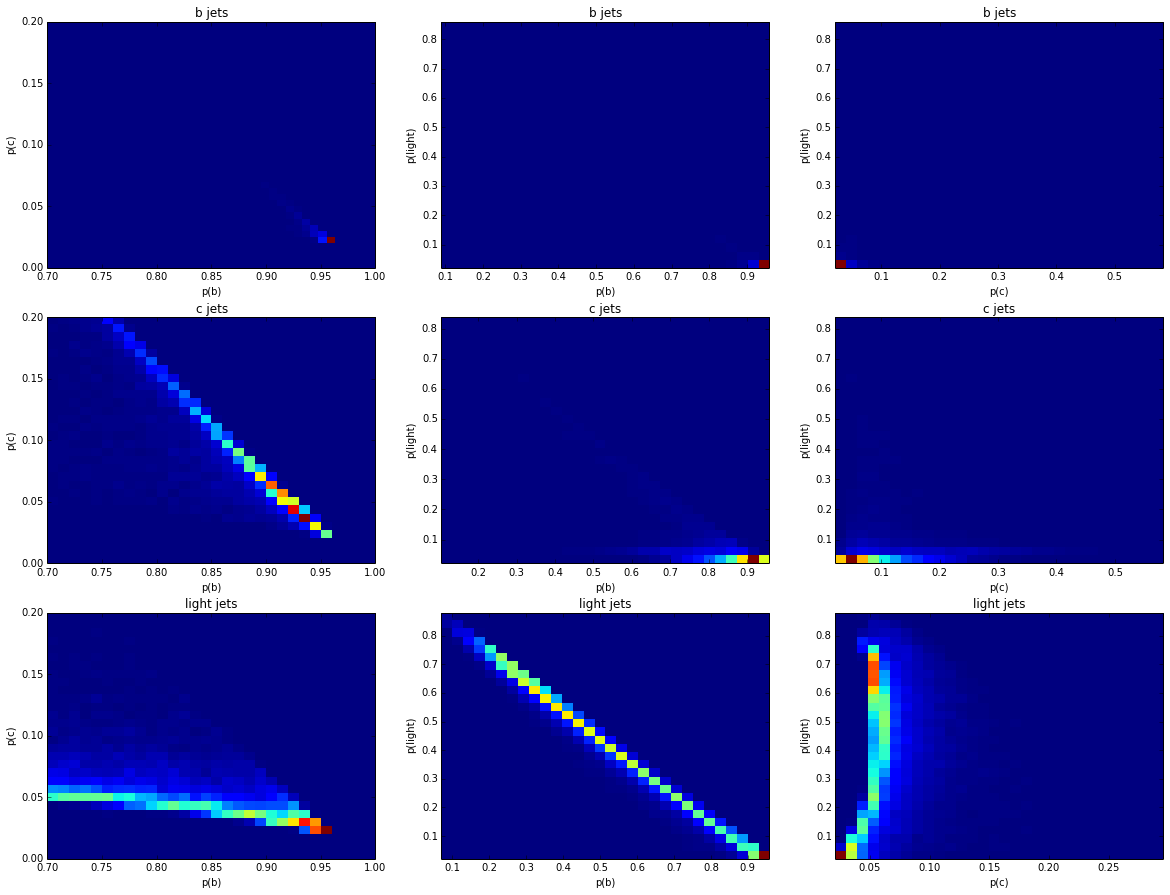

In [74]:
plt.figure(figsize=[20, 15])

plt.subplot(3,3,1)
hist2d(multi_probs_b[:, 0], multi_probs_b[:, 1], bins=40, range=[[0.7, 1], [0, 0.2]]), xlabel('p(b)'), ylabel('p(c)'), title('b jets')

plt.subplot(3,3,2)
hist2d(multi_probs_b[:, 0], multi_probs_b[:, 2], bins=30), xlabel('p(b)'), ylabel('p(light)'), title('b jets')

plt.subplot(3,3,3)
hist2d(multi_probs_b[:, 1], multi_probs_b[:, 2], bins=30), xlabel('p(c)'), ylabel('p(light)'), title('b jets')

plt.subplot(3,3,4)
hist2d(multi_probs_c[:, 0], multi_probs_c[:, 1], bins=30, range=[[0.7, 1], [0, 0.2]]), xlabel('p(b)'), ylabel('p(c)'), title('c jets')

plt.subplot(3,3,5)
hist2d(multi_probs_c[:, 0], multi_probs_c[:, 2], bins=30), xlabel('p(b)'), ylabel('p(light)'), title('c jets')

plt.subplot(3,3,6)
hist2d(multi_probs_c[:, 1], multi_probs_c[:, 2], bins=30), xlabel('p(c)'), ylabel('p(light)'), title('c jets')

plt.subplot(3,3,7)
hist2d(multi_probs_light[:, 0], multi_probs_light[:, 1], bins=30, range=[[0.7, 1], [0, 0.2]]), xlabel('p(b)'), ylabel('p(c)'), title('light jets')

plt.subplot(3,3,8)
hist2d(multi_probs_light[:, 0], multi_probs_light[:, 2], bins=30), xlabel('p(b)'), ylabel('p(light)'), title('light jets')

plt.subplot(3,3,9)
hist2d(multi_probs_light[:, 1], multi_probs_light[:, 2], bins=30), xlabel('p(c)'), ylabel('p(light)'), title('light jets')
pass

# Ranker

In [45]:
from hep_ml.gradientboosting import UGradientBoostingRegressor
from hep_ml.losses import RankBoostLossFunction

In [46]:
ranker_data = pandas.concat([data_b, data_c, data_light])
ranker_data['ranks'] = [0] * len(data_b) + [1] * len(data_c) + [2] * len(data_light)
multi_p_features = ['p_b', 'p_c', 'p_light']
for i, f in enumerate(multi_p_features):
    ranker_data[f] = multi_probs[:, i]

In [47]:
from sklearn.cross_validation import train_test_split

In [48]:
train, test = train_test_split(ranker_data, random_state=11, train_size=0.5)

In [ ]:
ranker = UGradientBoostingRegressor(loss=RankBoostLossFunction(request_column='ranks'), subsample=0.6, 
                                    n_estimators=400, max_depth=6, train_features=sv_features + multi_p_features)
%time ranker.fit(train, train['ranks'])

In [ ]:
ranks = ranker.predict(test)

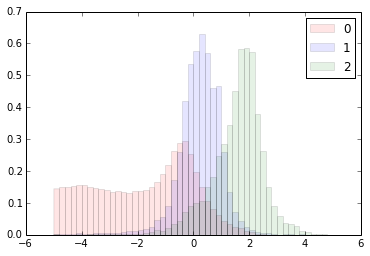

In [80]:
for label in numpy.unique(test.ranks.values):
    hist(ranks[test.ranks.values == label], bins=50, alpha=0.1, normed=True, range=(-5, 5), label=str(label))
legend()

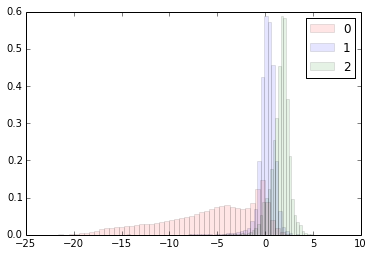

In [81]:
for label in numpy.unique(test.ranks.values):
    hist(ranks[test.ranks.values == label], bins=50, alpha=0.1, normed=True, label=str(label))
legend(loc='best')

In [82]:
print 'b vs all', 1 - roc_auc_score(test.ranks.values == 0, ranks)
print 'b vs c', 1 - roc_auc_score(test.ranks.values[test.ranks.values != 2] == 0, ranks[test.ranks.values != 2])
print 'c vs all', roc_auc_score(test.ranks.values == 1, ranks)
print 'light vs all', roc_auc_score(test.ranks.values == 2, ranks)

b vs all 0.962750589569
b vs c 0.924338853745
c vs all 0.906259166407
light vs all 0.979712382633


# Hierarchical multiclassification

# Questions:

* why c data is about 2* 10^6 and other is about 4 *10^4
* compare b vs c rocs and b,c vs light 